In [2]:
import numpy as np
from astropy import units
from astropy.io import fits
from astropy.table import Table
import pyccl as ccl
import healpy as hp
import sacc

from matplotlib import pyplot as plt

In [3]:
nside = 1024
npix = hp.nside2npix(nside)

# Get DELS number maps

In [4]:
bass_mzls_cat = Table.read('./data/Legacy_Survey_BASS-MZLS_galaxies-selection.fits')
decals_cat = Table.read('./data/Legacy_Survey_DECALS_galaxies-selection.fits')

In [5]:
ipix_bass = hp.ang2pix(nside,
                       bass_mzls_cat['RA'], bass_mzls_cat['DEC'],
                       lonlat=True)

ipix_decals = hp.ang2pix(nside,
                         decals_cat['RA'], decals_cat['DEC'],
                         lonlat=True)

In [6]:
bass_mzls_Nmap = np.bincount(ipix_bass, minlength=npix)
decals_Nmap = np.bincount(ipix_decals, minlength=npix)

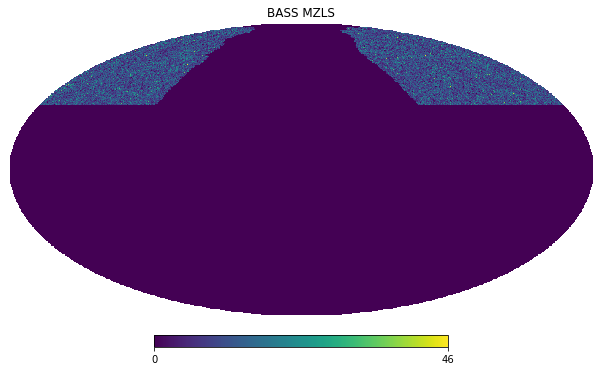

In [7]:
hp.mollview(bass_mzls_Nmap, title='BASS MZLS')

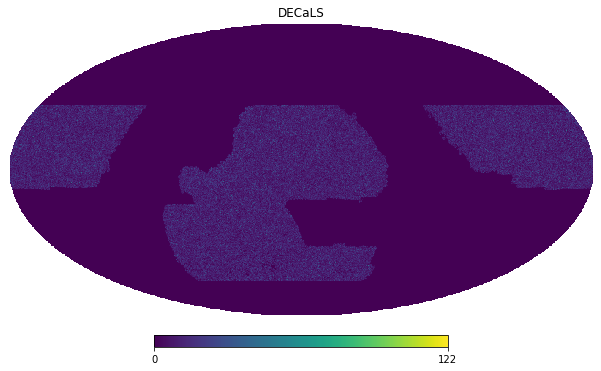

In [8]:
hp.mollview(decals_Nmap, title='DECaLS')

# Get DELS mask

In [9]:
final_mask = hp.read_map('./data/Legacy_footprint_final_mask.fits')
final_mask = hp.ud_grade(final_mask, nside_out=nside)

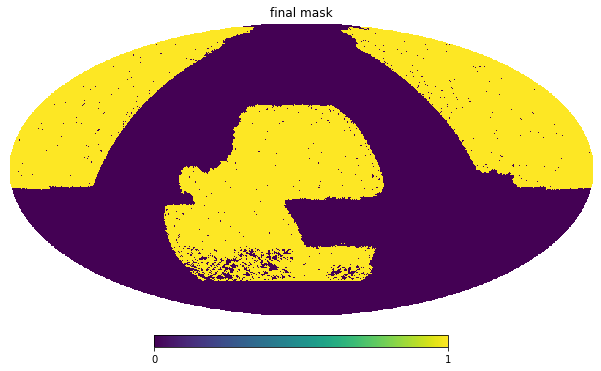

In [10]:
hp.mollview(final_mask, title='final mask')

# Get DELS completeness

In [11]:
comp_mask = hp.read_map('./data/Legacy_footprint_completeness_mask_128.fits')
comp_mask = hp.ud_grade(comp_mask, nside_out=nside)

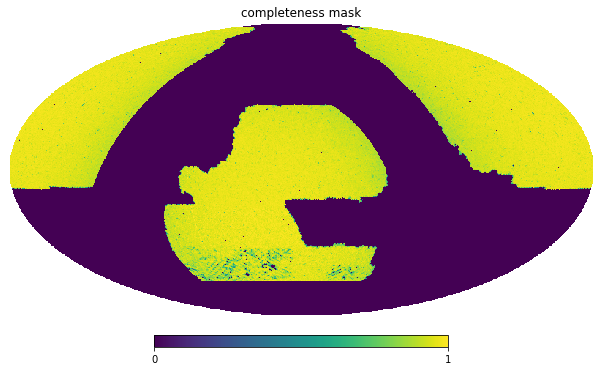

In [12]:
hp.mollview(comp_mask, title='completeness mask')

# Get stellar density map

In [13]:
star_map = hp.read_map('./data/allwise_total_rot_1024.fits')
star_map = hp.ud_grade(star_map, nside_out=nside, power=-2)

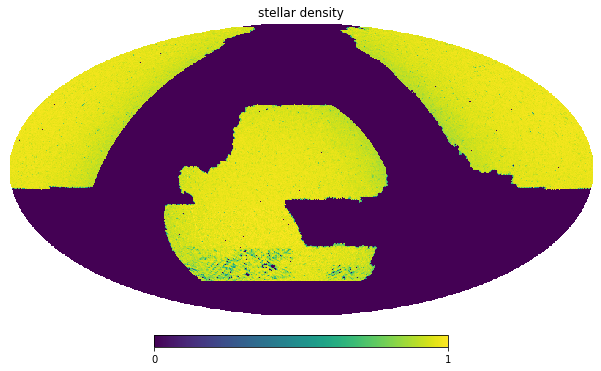

In [14]:
hp.mollview(comp_mask, title='stellar density')

# Convert to galaxy overdensity maps

In [15]:
pixmask = (comp_mask > 0.95) * (star_map < 8515) * (final_mask > 0)

In [16]:
bass_mzls_Nmean = np.sum(bass_mzls_Nmap[pixmask]) / np.sum(comp_mask[pixmask])

bass_mzls_deltamap = np.zeros_like(bass_mzls_Nmap, dtype=float)
bass_mzls_deltamap[pixmask] = bass_mzls_Nmap[pixmask] / (bass_mzls_Nmean*comp_mask[pixmask]) - 1
bass_mzls_deltamap[~pixmask] = np.nan

In [17]:
decals_Nmean = np.sum(decals_Nmap[pixmask]) / np.sum(comp_mask[pixmask])

decals_deltamap = np.zeros_like(decals_Nmap, dtype=float)
decals_deltamap[pixmask] = decals_Nmap[pixmask] / (decals_Nmean*comp_mask[pixmask]) - 1
decals_deltamap[~pixmask] = np.nan

In [18]:
dels_Nmap = bass_mzls_Nmap + decals_Nmap

dels_Nmean = np.sum(dels_Nmap[pixmask]) / np.sum(comp_mask[pixmask])

dels_deltamap = np.zeros_like(dels_Nmap, dtype=float)
dels_deltamap[pixmask] = dels_Nmap[pixmask] / (dels_Nmean*comp_mask[pixmask]) - 1
dels_deltamap[~pixmask] = np.nan

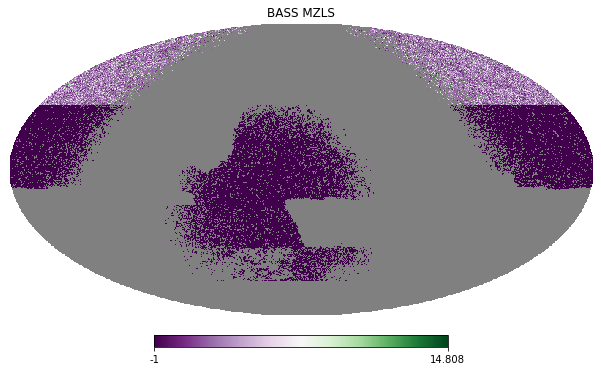

In [19]:
hp.mollview(bass_mzls_deltamap, title='BASS MZLS', cmap='PRGn')

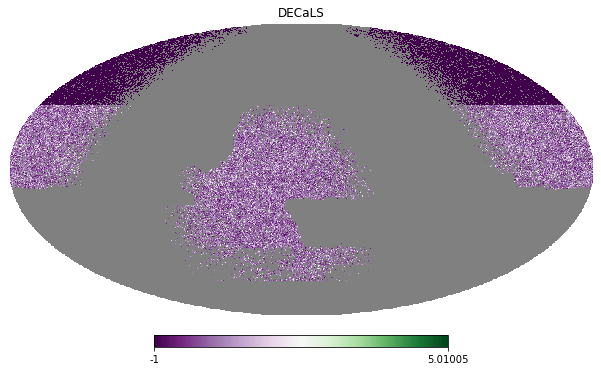

In [20]:
hp.mollview(decals_deltamap, title='DECaLS', cmap='PRGn')

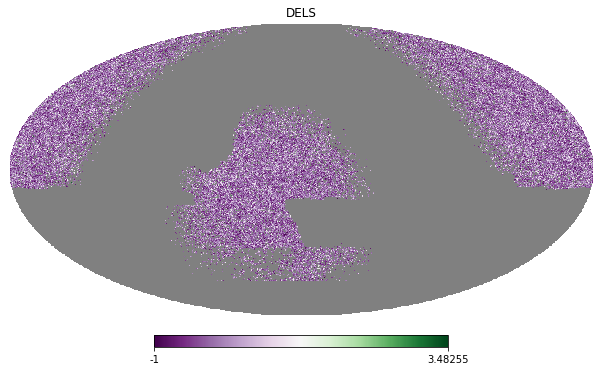

In [21]:
hp.mollview(dels_deltamap, title='DELS', cmap='PRGn')

# Get $gg$ rough power spectrum

In [23]:
import pymaster as nmt

In [104]:
apmask = nmt.mask_apodization(final_mask,
                              1., apotype="Smooth")

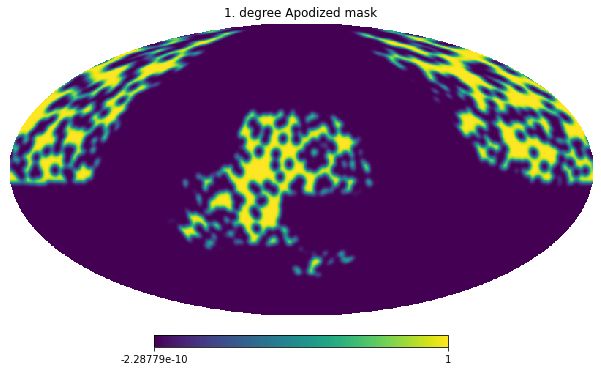

In [105]:
hp.mollview(apmask, title='1. degree Apodized mask')

In [101]:
dels_deltamap[np.isnan(dels_deltamap)] = 0.
f_0 = nmt.NmtField(apmask, [dels_deltamap])
f_0_nomask = nmt.NmtField(final_mask, [dels_deltamap])

In [82]:
b = nmt.NmtBin.from_nside_linear(nside, 4)

In [102]:
cl_00 = nmt.compute_full_master(f_0, f_0, b)
cl_00_nomask = nmt.compute_full_master(f_0_nomask, f_0_nomask, b)

In [84]:
import pyccl as ccl

cosmo = ccl.Cosmology(Omega_c=0.25,
                      Omega_b=0.05,
                      h=0.7,
                      n_s=0.965,
                      A_s=2.11e-9,
                      Omega_k=0.0,
                      Neff=3.046,
                      matter_power_spectrum='linear')

In [85]:
dndz_decals = np.loadtxt('./data/nzs_DECALS.txt')

Asky_decals = 17739 * units.deg * units.deg
fsky_decals = Asky_decals.value / 41253

Ngal_decals = np.array([14363105, 11554242, 13468310, 7232579]) / Asky_decals
ngal_decals = Ngal_decals.to(1 / (units.arcmin * units.arcmin))
ngal_decals_total = [ngal_decals.value.sum()] / (units.arcmin * units.arcmin)

b1_decals = [1.25, 1.56, 1.53, 1.83]
b2_decals = [1.26, 1.88, 1.84, 2.19]
b1_decals_total = [1.43]

s1_decals = [0.19, 0.29, 0.41, 0.57]
s1_decals_total = [np.mean(s1_decals)]

dndz_decals_total = np.column_stack([dndz_decals[:,0], np.einsum('i,...i', ngal_decals, dndz_decals[:,1:]).value])

In [86]:
def setup_galaxy_tracers(cosmo, dndz, b1, s1):
    
    tracer_list = []
    
    for ibin in np.arange(1,dndz.shape[-1]):
        
        tracer_list.append(ccl.NumberCountsTracer(cosmo,
                                                  has_rsd=False,
                                                  dndz=(dndz[:,0], dndz[:,ibin-1]),
                                                  bias=(dndz[:,0], b1[ibin-1] * np.ones(len(dndz[:,0]))), 
                                                  mag_bias=(dndz[:,0], s1[ibin-1] * np.ones(len(dndz[:,0])))
                                                  )
                      )
    
    return tracer_list

decals_total_tracer = setup_galaxy_tracers(cosmo, dndz_decals_total, b1_decals_total, s1_decals_total)[0]

In [87]:
cl_gg_theory = ccl.angular_cl(cosmo, decals_total_tracer, decals_total_tracer, ell_arr)

In [94]:
Nell_dels_g= np.ones_like(ell_arr) / (ngal_decals_total.value * (60 * 180 / np.pi)**2)

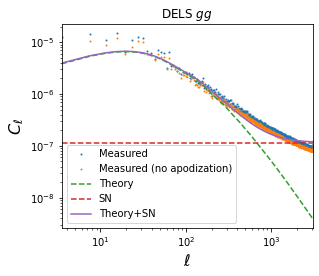

In [109]:
plt.close(1)
plt.figure(1, figsize=(4.5, 3.75))
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_00[0], 'o', ms=1, label='Measured')
plt.plot(ell_arr, cl_00_nomask[0], 'o', ms=1, label='Measured (no apodization)')
plt.plot(ell_arr, cl_gg_theory, '--', ms=1, label='Theory')
plt.plot(ell_arr, Nell_dels_g, '--', ms=1, label='SN')
plt.plot(ell_arr, Nell_dels_g+cl_gg_theory, '-', ms=1, label='Theory+SN')
plt.loglog()
plt.xlim([ell_arr.min(), ell_arr.max()])
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left')
plt.title('DELS $gg$')
plt.savefig('plots/cl-gg-rough.png', dpi=300, bbox_inches='tight');

# Correction for stellar density

In [ ]:
# nbins = 14
# star_bins = np.linspace(np.log10(star_map[final_mask > 0].min()),
#                         np.log10(star_map[final_mask > 0].max()),
#                         nbins + 1)

# d_mean = []
# d_std = []

# for ibin, stard in enumerate(star_bins[:-1]):
    
#     stellar_bin = (st <= np.log10(star_map) <= stbins[ibin + 1])
#     delta = decals_deltamap
    